In [ ]:
! pip install pingouin
import pandas as pd
import seaborn as sns
from datetime import datetime
import numpy as np
from scipy.stats import levene
import pingouin as pg
import scipy.stats as ss
from itertools import combinations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
sns.set(
    rc={
        "figure.figsize": (8, 4), #размер графика - 12 дюймов в ширину, 8 в длину
        "axes.titlesize": 14, #размер заголовка 
        "axes.labelsize": 10, #размер подписей осей
        "xtick.labelsize": 8, #размер подписей чёрточек на x-оси
        "ytick.labelsize": 8, #размер подписей чёрточек на y-оси
    }
)
sns.set_style("whitegrid") #тема фона, белая со штриховкой

# Описание данных
В переменные users и purchases (pands.DataFrame) уже загружены данные о пользователях, попавших в а/б тест и их покупках.

А/б тест направлен на улучшение платежной активности пользователей. Вам дан датасет с транзакциями пользователей до и во время теста в контрольной и тестовых группах

Задача:


*   ознакомиться с данными
*   Исходя из имеющихся данных посчитать 2-3 метрики по группам; объяснить свой выбор




Описание данных:

В таблице users_ приведена информация о том, какой юзер в какой момент времени попал в а/б тест:
- tag - лэйбл группы (control - контрольная, остальные - тестовые)
*ts - время, когда впервые был выдан tag. То есть, все события до наступления времени ts происходили с юзером до попадания в а/б тест
*user_uid - внутренний id юзера (для матчинга со второй таблицей)
*registration_time - время регистрации пользователя в сервисе
*conv_ts - время совершения первой покупки пользователем в сервисе

В таблице purchases_ приведена информация о транзакциях пользователей из таблицы users_ до и во время а/б теста:
- user_uid - внутренний id юзера (для матчинга со второй таблицей)
*time - время совершения транзакции
*consumption_mode - вид потребления контента (dto - единица контента куплена навсегда, rent - единица контента взята в аренду, subscription - оформлена подписка)
*element_uid - уникальный id единицы контента или подписки
*price - цена (преобразованная)

Значения в полях price и всех полях, указывающих на время - преобразованы. Это значит, что значение в таблице не настоящее, но является линейным преобразованием реального значения, где ко всем значениям одного поля применено одно и то же преобразование - между ними сохранено отношение порядка. Ко всем полям, обозначающим время, применено одно и то же преобразование.




# Знакомство с данными

## users

In [ ]:
users.head()

,tag,ts,user_uid,registration_time,conv_ts
0,test4,30152.843868,001885550d78efd82c0f5cc02ad3369a,27410.154590,29485.529691
1,control,30133.146255,deb7d0e9bf9813d4f21b579d3703c6e1,27410.171795,27632.424734
2,test1,30140.447675,32095e22f853e595a0f407ad081e7da8,27410.217536,27414.028899
3,control,30136.790772,9932d33f40ad07d7f3ddb7c6aee1bc60,27410.227367,27573.751226
4,test2,30150.339264,4a122db1ad0214e969df154d2dbb4622,27410.230786,29545.833019


In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696982 entries, 0 to 696981
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   tag                696982 non-null  object 
 1   ts                 696982 non-null  float64
 2   user_uid           696982 non-null  object 
 3   registration_time  696485 non-null  float64
 4   conv_ts            696697 non-null  float64
dtypes: float64(3), object(2)
memory usage: 26.6+ MB


In [ ]:
users.isna().mean()

tag                  0.000000
ts                   0.000000
user_uid             0.000000
registration_time    0.000713
conv_ts              0.000409
dtype: float64

In [ ]:
users.duplicated().sum()

0

In [ ]:
users['tag'].value_counts() # 5 групп

test1      140133
test2      139389
test4      139254
test3      139226
control    138980
Name: tag, dtype: int64

In [ ]:
# есть дублирующиеся записи пользователей
users['user_uid'].nunique()

694819

In [ ]:
double_users = users.groupby('user_uid')[['tag']] \
                    .agg('count') \
                    .sort_values('tag', ascending=False) \
                    .query('tag > 1') \
                    .reset_index()['user_uid'] \
                    .to_list()

In [ ]:
users.groupby('user_uid')[['tag']] \
                    .agg('count') \
                    .sort_values('tag', ascending=False) \
                    .query('tag > 1') \
                    .reset_index()['tag'].value_counts()

2    2032
3      61
4       3
Name: tag, dtype: int64

In [ ]:
len(double_users) # число юзеров, которые попали в несколько групп

2096

In [ ]:
# пример
users.query('user_uid == "6c2289ccfa50dd5b669b159fe12ca4ed"').sort_values('ts')

,tag,ts,user_uid,registration_time,conv_ts
93037,test3,30133.872325,6c2289ccfa50dd5b669b159fe12ca4ed,28692.364445,28906.943711
103896,control,30136.492787,6c2289ccfa50dd5b669b159fe12ca4ed,28692.364445,28906.943711
90820,test3,30136.593332,6c2289ccfa50dd5b669b159fe12ca4ed,28692.364445,28906.943711
97224,test4,30140.554481,6c2289ccfa50dd5b669b159fe12ca4ed,28692.364445,28906.943711


## Выводы по дубликатам юзеров
- А/Б тест проходит с пересечением, при чем пересечений у некоторых доходит до 4. Бывают такие дизайны экспериментов, когда возможны пересечения между группами (например для повышения мощности теста или если изменение не являются взаимоисключающими), однако в данном случае я не думаю, что 2к юзеров существенно влияют на выборку из почти 700к пользоваталей.
- по хорошему нужно чинить систему сплитования и провести А/Б/n тест еще раз, потому что эксперименты со сломанной системой сплитования бессмысленны

Я же пойду по другому: удалю этих пользоваталей вообще и буду считать, что система сплитования работает отлично. В реальной жизни я бы так не стал делать.

In [ ]:
# ради интереса посмотрим распределение конверсионного окна в первую покупку
users['conv_w'] = users['conv_ts'] - users['registration_time']

<Axes: >

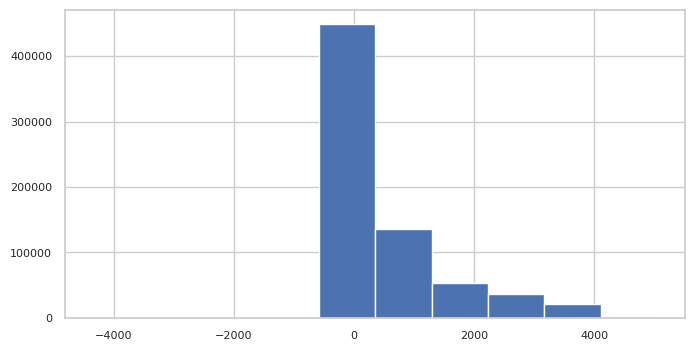

In [ ]:
users['conv_w'].hist()

Были пользователи, которые сделали покупку до регистрации. Рассмотрим сколько их, посмотрим на распределение

In [ ]:
len(users.query('conv_w < 0')['conv_w']) # более 100к покупок

106553

<Axes: xlabel='conv_w'>

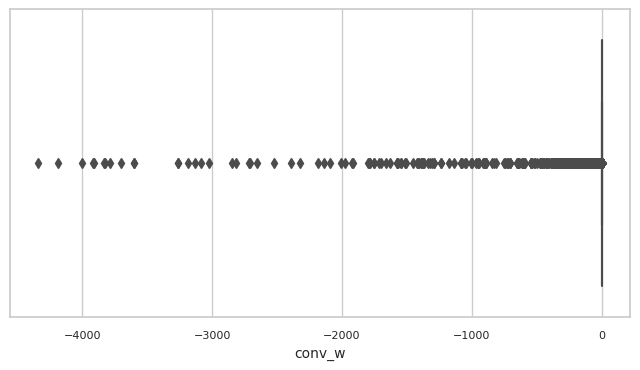

In [ ]:
sns.boxplot(x = users.query('conv_w < 0')['conv_w'])

<Axes: xlabel='conv_w'>

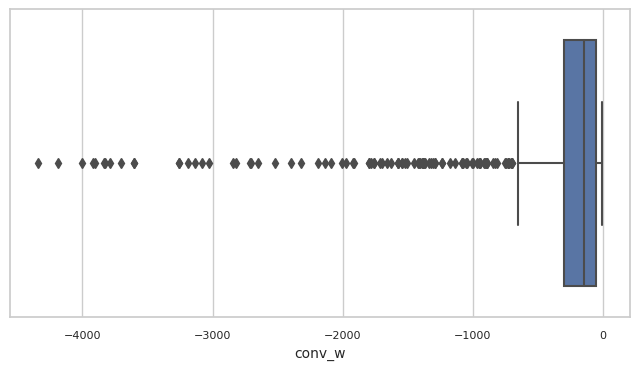

In [ ]:
sns.boxplot(x = users.query('conv_w < -10')['conv_w'])

Большая часть регистрировалась почти сразу после покупки (точно сказать нельзя, потому что неизвестно преобразование). Допустим, это формат экселя, тогда:

In [ ]:
min_w = users['conv_w'].min()
users.query('conv_w == @min_w')

,tag,ts,user_uid,registration_time,conv_ts,conv_w
384462,control,30132.337289,382dd4f14e9c71bedf96129d1092521e,30236.162948,25896.598883,-4339.564065


In [ ]:
datetime.fromtimestamp(30236.162948).strftime('%Y-%m-%d %H:%m:%s')

'1970-01-01 08:01:30236'

In [ ]:
datetime.fromtimestamp(25896.598883).strftime('%Y-%m-%d %H:%m:%s')

'1970-01-01 07:01:25896'

In [ ]:
max_w = users['conv_w'].max()
users.query('conv_w == @max_w')

,tag,ts,user_uid,registration_time,conv_ts,conv_w
623227,test4,30135.654241,35784b505846a4222351f6ac5fa58780,25078.430701,30129.308458,5050.877758


In [ ]:
print(datetime.fromtimestamp(25078.430701).strftime('%Y-%m-%d %H:%m:%s'))
print(datetime.fromtimestamp(30129.308458).strftime('%Y-%m-%d %H:%m:%s'))

1970-01-01 06:01:25078
1970-01-01 08:01:30129


Скорее всего было выполнено другое преобразование, однако, если это, то максимальная разница между регистрацией и покупкой 2 часа.

Далее рассмотрим покупки.
## purchases

In [ ]:
purchases.head()

,user_uid,time,consumption_mode,element_uid,price
0,d60a7038c7b7e99146ffea6f6535862b,30158.645112,dto,2ba66ac9785731da67b2b6155efaca5c,44.470588
1,0906074e1a1a9229b5e749860b646962,30158.645015,dto,e56d422275d90c96762f81db85d80f3d,38.588235
2,efb6eeca3135d573739e5c5d4dbce330,30158.644990,dto,544f7dd31bd61558c9c738adcff6aafa,50.352941
3,ccd658e372645c991ce49b444839712f,30158.644789,dto,8256d0fc7b25382aacfec0066e39cde3,44.470588
4,89ae5e43ff7b89f9d262d507dedc1760,30158.644200,dto,a579f32b5c116624cc661c9d3b96d5e5,44.470588


In [ ]:
purchases.info() # пропусков нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663849 entries, 0 to 663848
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_uid          663849 non-null  object 
 1   time              663849 non-null  float64
 2   consumption_mode  663849 non-null  object 
 3   element_uid       663849 non-null  object 
 4   price             663849 non-null  float64
dtypes: float64(2), object(3)
memory usage: 25.3+ MB


In [ ]:
purchases.duplicated().sum()

0

In [ ]:
purchases['user_uid'].nunique() # половина пользователей сделала минимум 1 покупку

295200

In [ ]:
purchases['element_uid'].nunique()

6813

<Axes: >

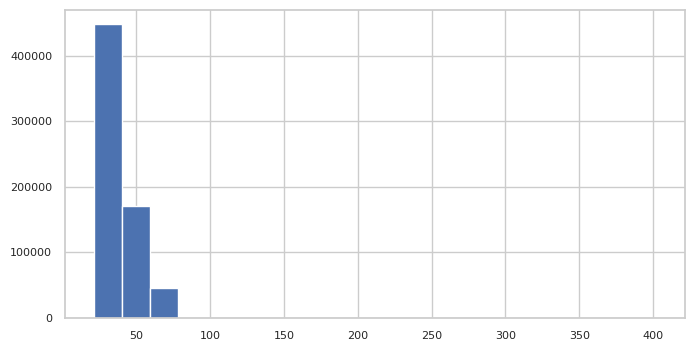

In [ ]:
purchases['price'].hist(bins=20)

<Axes: xlabel='price'>

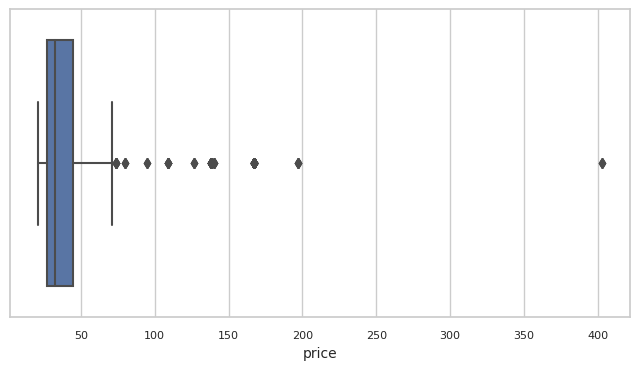

In [ ]:
sns.boxplot(x = purchases['price'])

<Axes: xlabel='price', ylabel='consumption_mode'>

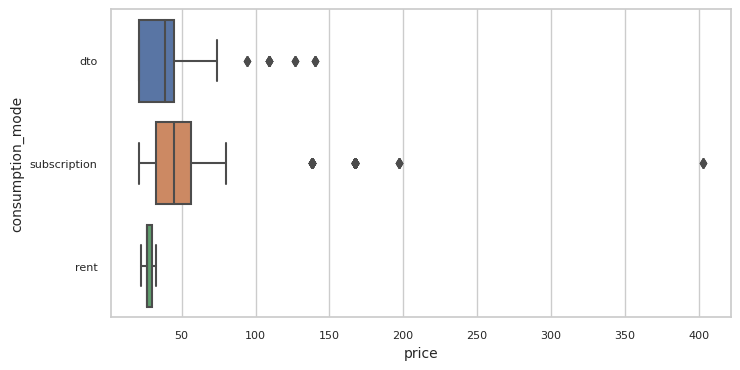

In [ ]:
# Рассмотрим траты по категориям
sns.boxplot(data=purchases, x='price', y='consumption_mode')

In [ ]:
purchases['consumption_mode'].value_counts()

dto             245276
subscription    239897
rent            178676
Name: consumption_mode, dtype: int64

In [ ]:
# варианты подписок
purchases.query('consumption_mode == "subscription"')['element_uid'].nunique()

17

In [ ]:
purchases.query('consumption_mode == "dto"')['element_uid'].nunique()

5387

In [ ]:
purchases.query('consumption_mode == "rent"')['element_uid'].nunique()

5084

In [ ]:
purchases.query('consumption_mode == "subscription"') \
        .groupby('price') \
        .agg({'user_uid':'count'}) \
        .sort_values('user_uid', ascending=False)

,user_uid
price,
32.705882,60101
44.470588,46044
68.000000,45554
38.588235,37137
56.235294,31264
21.058824,10589
50.352941,4821
53.294118,2803
35.647059,618


In [ ]:
# покупки пользователей из пересечений
purchases.query('user_uid in @double_users')

,user_uid,time,consumption_mode,element_uid,price
175,f93fd3d77354b58dfd19ca87ca4a7ec6,30158.617484,dto,7af6df3758b7e4729261a7f56db60aae,38.588235
223,b80eeae67ca6fe26d9f4adbc0e567a55,30158.611271,dto,a5350e34697ae064a5e65c2e46e6b037,21.058824
348,0a709d0fcf5d2215671ab511c45b1727,30158.597767,dto,cb96963fab63f5aa274c1d5fb441c52a,44.470588
378,f7bd3458108297d0b793c7402cdd3abe,30158.593757,dto,ce0707f6b5e575c4def98f35a4c02c59,38.588235
408,1c9b0952cd7e79be29a7da9b0885df56,30158.590351,dto,8256d0fc7b25382aacfec0066e39cde3,38.588235
...,...,...,...,...,...
663353,41264207fc231c5cc036866e437687e7,30106.516782,dto,5aa724c0393087cde3a18c625b310645,21.058824
663519,a250b44c72153f6dd510e752629b3089,30106.508138,rent,0a5d74a8a6efa47f7b790e5d0468842b,26.823529
663579,2122226ec9fd99ff20b6086915bd4bb4,30106.504572,subscription,dd7f3f7b10fb9b502cbc5d1a9abc067b,21.058824
663590,83dee65e8616fb19955569673985db4a,30106.504015,subscription,dd7f3f7b10fb9b502cbc5d1a9abc067b,44.470588


Наименьший разброс по тратам у контента, взятого в аренду, наибольший - контент по подписке. При этом разная цена подписки возможно означает вариативность тарифного плана и числа месяцев (или другой временной единицы). Последнее объясняет выбросы. Также возможен вариант применения промокода

# Проверка результатов А/Б/n теста
Как и писал выше, для начала надо удалить пользоваталей в пересечениях. Возможно это скажется на мощности, но как интерпритировать множественное сравнение с пересечениями, я плохо понимаю.

Чтобы посчитать ту же конверсию, нам нужны пользователи, которые делали и не делали покупок, поэтому левой таблицей будут пользователи, правой - покупки. После мерджа необходимо отобрать только те записи, где покупки были совершены после присвоения группы. Также надо не забыть про пустые записи - покуппок не было.

In [ ]:
users_not_d = users.query('user_uid not in @double_users')

In [ ]:
users_not_d['user_uid'].nunique() == len(users_not_d)

True

In [ ]:
t = users_not_d.merge(purchases, how='left', on='user_uid')

In [ ]:
len(t)

1058881

In [ ]:
# отберем пользоваталей по условию
pre_final_table = t.query('ts < time or time != time')

In [ ]:
len(pre_final_table)

675358

In [ ]:
len(pre_final_table.query('time == conv_ts'))

0

Ни одна из покупок не является первой. Варианты, почему так:
- так и есть
- возможно время транзакций не совпадает с покупкой (разница в секундах, что обнаружить на таких данных не получится)
- моя ошибка, но вроде все перепроверил:)

## Выбор метрик
Исходя из данных, можно проверить следующие метрики
1. ARPU - сколько в среднем приходится на пользователя
2. ARPPU (AOV) - средняя сумма на платящего пользователя
3. Конверсия в покупку
4. Среднее число покупок на пользователя APC

In [ ]:
# оставим нужное
final_table = pre_final_table[['tag', 'user_uid', 'consumption_mode', 'price']]

In [ ]:
final_table = final_table.fillna({'price': 0})

In [ ]:
purchases['price'].sum() # сравним суммы до и после соединения

24523353.11764706

In [ ]:
t['price'].sum()  # здесь меньше, что хорошо

24390995.823529404

## ARPU
Для множественных сравнений годится дисперсионный анализ (однофакторный в данном случае, F-тест). Так как выборки достаточно большие во всех группах, то условеим для применения теста Фишера является гомогенность дисперсий во всех группах.

<Axes: xlabel='price', ylabel='tag'>

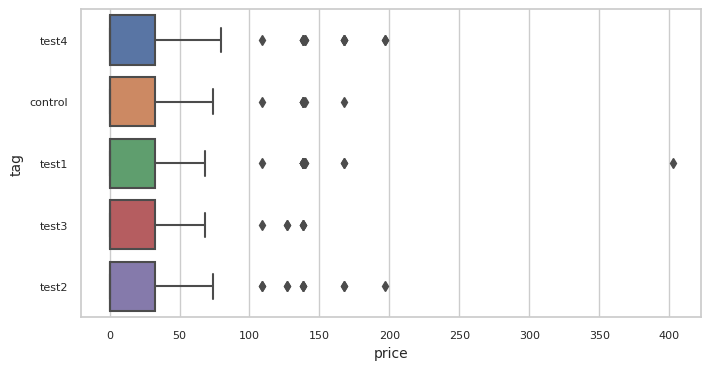

In [ ]:
sns.boxplot(data=final_table, x='price', y='tag') # половина 0

<Axes: xlabel='price', ylabel='tag'>

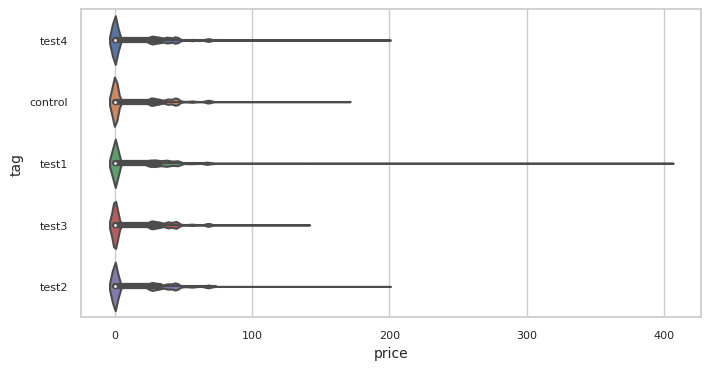

In [ ]:
sns.violinplot(data=final_table, x='price', y='tag')

<Axes: >

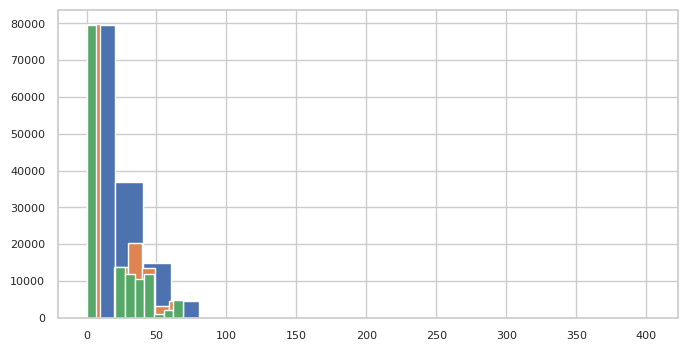

In [ ]:
# посмотрим на некотореы распределения
final_table.query('tag == "test1"')['price'].hist(bins=20)
final_table.query('tag == "test2"')['price'].hist(bins=20)
final_table.query('tag == "test3"')['price'].hist(bins=20)

Распределение скошено влево, имеются жирные хвосты во всех группах. Посмотрим на дисперсии

In [ ]:
test1 = np.array(final_table.query('tag == "test1"')['price'])
test2 = np.array(final_table.query('tag == "test2"')['price'])
test3 = np.array(final_table.query('tag == "test3"')['price'])
test4 = np.array(final_table.query('tag == "test4"')['price'])
control = np.array(final_table.query('tag == "control"')['price'])

Выдвигаемые гипотезы:

**H0: во всех группах дисперсии равны**

**H1: дисперсии в группах не равны**

**альфа=0.05**

In [ ]:
stat, p = levene(test1, test2, test3, test4, control)
p

1.0419932212553528e-10

p-value оказался меньше заданной ошибки первого рода. Поэтому нулевая гипотеза о гомогенности дисперсий отвергается. В таком случае можно воспользоваться дисперсионным анализом Уэлча



In [ ]:
pg.welch_anova(data=final_table,
               dv='price',
               between='tag')

,Source,ddof1,ddof2,F,p-unc,np2
0,tag,4,337622.354373,13.115009,1.107428e-10,0.000078


p-value меньше заданной альфа, значит мы праве отвергнуть нулевую гипотезу о равенстве средних. При этом размер эффекта близок к 0. Далее нужно попарно сравнить выборки и найти, где есть отличия. Для этого необходимо воспользоваться тестом Геймса-Хоувелла, который используется при попарном сравнении выборок с разной дисперсией.

Также необходима корректировка вероятности ошибки первого рода: сравнений 10, поэтому воспользуемся самой консервативной корректировкой - поправкой Бонферрони, когда альфа делится на число сравнений.

Выдвигаемые гипотезы:

**H0: средние двух сравниваемых групп равны**

**H1: средние двух сравниваемых групп не равны**

**альфа = 0.005**

In [ ]:
pg.pairwise_gameshowell(data=final_table, 
                        dv='price', 
                        between='tag')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,control,test1,15.361394,15.860310,-0.498916,0.079023,-6.313576,268287.452501,2.724985e-09,-0.024372
1,control,test2,15.361394,15.795553,-0.434158,0.079112,-5.487878,267748.319001,4.054249e-07,-0.021207
2,control,test3,15.361394,15.821018,-0.459623,0.079033,-5.815590,267994.548911,6.031582e-08,-0.022462
3,control,test4,15.361394,15.749216,-0.387822,0.078891,-4.915910,267963.748114,8.750427e-06,-0.018987
4,test1,test2,15.860310,15.795553,0.064758,0.078572,0.824181,271443.502633,9.232574e-01,0.003164
5,test1,test3,15.860310,15.821018,0.039293,0.078492,0.500594,271734.456279,9.873291e-01,0.001921
6,test1,test4,15.860310,15.749216,0.111094,0.078349,1.417936,271757.535051,6.160327e-01,0.005440
7,test2,test3,15.795553,15.821018,-0.025465,0.078582,-0.324053,271133.418367,9.976207e-01,-0.001245
8,test2,test4,15.795553,15.749216,0.046337,0.078440,0.590732,271147.380933,9.765077e-01,0.002269
9,test3,test4,15.821018,15.749216,0.071802,0.078360,0.916309,271442.210658,8.907493e-01,0.003517


Между контрольной и тестовыми группами есть статистически значимая разница, все тестовые варианты, согласно таблице выше, лучше контрольной. При этом нет статистически значимой разницы между тестовыми вариантами.

**Таким образом, нулевая гипотеза о равенстве средних между контрольной группой и тестовыми отклоняется.**

В данном случае средняя выручка на пользователя выше в тестовых группах, чем в контрольной.

## AOV

In [ ]:
# возьмем данные, где цена выше 0
final_table_not_zero = final_table.query('price > 0')

<Axes: xlabel='price', ylabel='tag'>

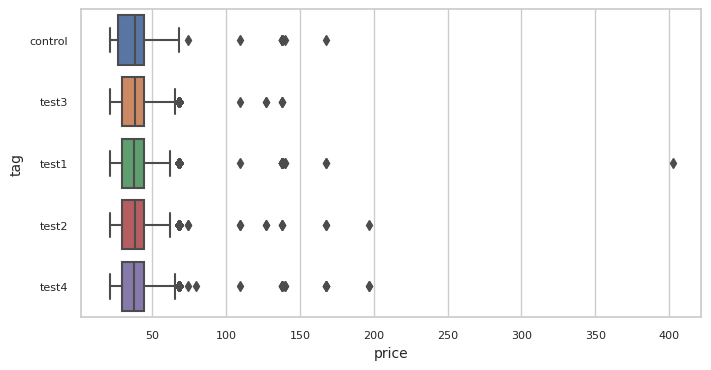

In [ ]:
# посмотрим на распределения сверху
sns.boxplot(data=final_table_not_zero, x='price', y='tag')

<Axes: xlabel='price', ylabel='tag'>

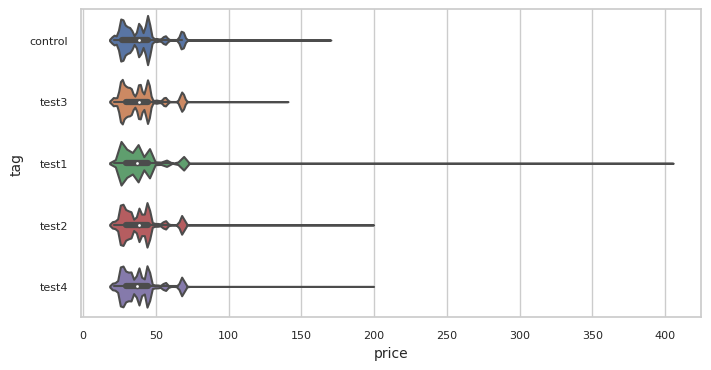

In [ ]:
sns.violinplot(data=final_table_not_zero, x='price', y='tag')

Можно заметить, что распределения имеют 3 своеобразных ценовых кластера, что равно числу видов контента для покупки. Наиболее часто покупают самый дешевый вид контента, вторым по популярности является самый дорогой.

Ради интереса посмотрим, какой из них дешевый и дорогой.

<Axes: xlabel='price', ylabel='Count'>

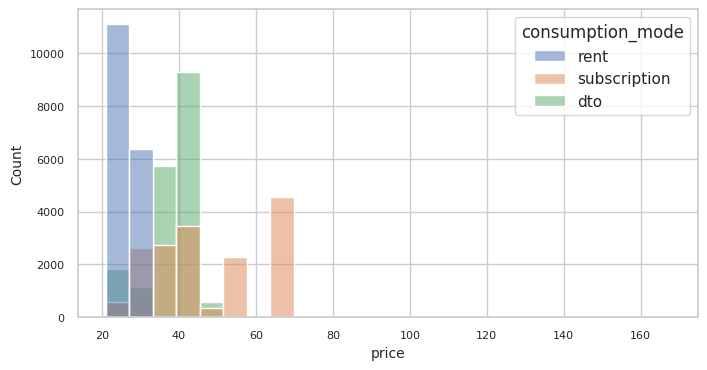

In [ ]:
sns.histplot(final_table_not_zero.query('tag == "control"')[['price', 'consumption_mode']], hue='consumption_mode', x='price', bins=24)

<Axes: xlabel='price', ylabel='consumption_mode'>

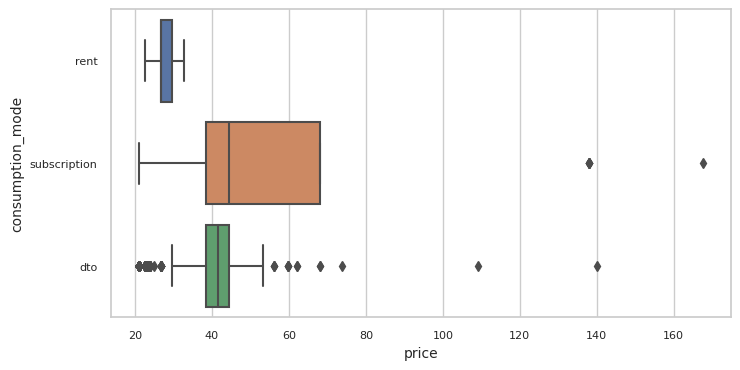

In [ ]:
sns.boxplot(final_table_not_zero.query('tag == "control"')[['price', 'consumption_mode']], y='consumption_mode', x='price')

Самый дешевый, но наиболее часто покупаемый - аренда, второй - покупка навсегда, третий - подписка).

Для сравнения средних чеков на пользователя также подходит однофакторный дисперсионный анализ, как и в предыдущем пункте. Проверим выборки на гомогенность дисперсий.

Выдивгаемые гипотезы:

**H0: во всех группах дисперсии равны**

**H1: дисперсии в группах не равны**

**альфа=0.05**

In [ ]:
test1_ = np.array(final_table_not_zero.query('tag == "test1"')['price'])
test2_ = np.array(final_table_not_zero.query('tag == "test2"')['price'])
test3_ = np.array(final_table_not_zero.query('tag == "test3"')['price'])
test4_ = np.array(final_table_not_zero.query('tag == "test4"')['price'])
control_ = np.array(final_table_not_zero.query('tag == "control"')['price'])
stat, p = levene(test1_, test2_, test3_, test4_, control_)
p

1.664955946418671e-13

Снова p-value меньше альфа, а значит H0 отвергается, поэтому воспользуемся такими же критерями, что и при сравнении ARPU:

In [ ]:
pg.welch_anova(data=final_table_not_zero,
               dv='price',
               between='tag')

,Source,ddof1,ddof2,F,p-unc,np2
0,tag,4,138228.39691,9.712387,7.501606e-08,0.000142


Также есть стат значимые различия между группами. Воспользуемся парным критерием Геймса-Хоувелла.

Выдвигаемые гипотезы:

**H0: средние двух сравниваемых групп равны**

**H1: средние двух сравниваемых групп не равны**

**альфа = 0.005**

In [ ]:
pg.pairwise_gameshowell(data=final_table_not_zero, 
                        dv='price', 
                        between='tag')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,control,test1,38.618944,38.280936,0.338008,0.075283,4.489840,108403.807233,6.982864e-05,0.027217
1,control,test2,38.618944,38.399636,0.219308,0.075227,2.915305,107825.560672,2.925711e-02,0.017725
2,control,test3,38.618944,38.322629,0.296315,0.075125,3.944298,108051.561365,7.625033e-04,0.023949
3,control,test4,38.618944,38.174531,0.444413,0.075103,5.917373,108017.656082,3.266669e-08,0.035934
4,test1,test2,38.280936,38.399636,-0.118700,0.073585,-1.613100,112059.993361,4.888860e-01,-0.009637
5,test1,test3,38.280936,38.322629,-0.041693,0.073481,-0.567398,112381.758946,9.797577e-01,-0.003385
6,test1,test4,38.280936,38.174531,0.106404,0.073459,1.448489,112353.624983,5.961361e-01,0.008642
7,test2,test3,38.399636,38.322629,0.077007,0.073424,1.048806,111728.374748,8.324988e-01,0.006275
8,test2,test4,38.399636,38.174531,0.225105,0.073401,3.066775,111699.899826,1.841669e-02,0.018352
9,test3,test4,38.322629,38.174531,0.148098,0.073297,2.020514,112023.985286,2.560148e-01,0.012073


Есть статистически значимые различия между средними:
- контрольной группы и test1
- контрольной группой и test3
- контрольной группой и test4

В этих случаях мы отклоняем нулевую гипотезу о разности средних групп. Во всех остальных сравнения H0 отклонить нет оснований.

При чем разница получилась не в пользу тестовых групп. Почему так может произойти? Возможно, покупать стали больше, но покупки недорогие. Проверим CR.

## Конверсия в покупку

В данном случае будем учитывать только факт покупки пользователем - так узнаем, какой % пользоваталей делал покупки.

Будем рассчитывать по следующей формуле: 

`число платящих пользоваталей / число пользователей`

Для нахождения значений достаточно взять уникальное число пользоваталей из таблиц, где считали AOV и ARPU.


In [ ]:
all_users = final_table.groupby('tag')[['user_uid']] \
                    .agg('nunique') \
                    .reset_index() \
                    .rename(columns={'user_uid': 'all_users'})

In [ ]:
payment_users = final_table_not_zero.groupby('tag')[['user_uid']] \
                    .agg('nunique') \
                    .reset_index() \
                    .rename(columns={'user_uid': 'payment_users'})

In [ ]:
cr = payment_users.merge(all_users, on='tag') # по умолчанию инер джойн

In [ ]:
cr

,tag,payment_users,all_users
0,control,29872,109643
1,test1,31295,110963
2,test2,30863,110582
3,test3,30949,110634
4,test4,30979,110716


Для полученных пропорций можно использовать критерий Хи-квадрат

Гипотезы:

**H0: между группами нет связи**

**H1: группы связаны**

**альфа = 0.05**

In [ ]:
data = np.array([[29872, 109643], [31295, 110963], [30863, 110582], 
                 [30949, 110634], [30979, 110716]])
chi2, pval, dof, expected = ss.chi2_contingency(data)
print(chi2, pval, dof, sep='\n')

16.2924826993011
0.002650787969462448
4


Так как p-value меньше альфа, следовательно H0 отвергается. Далее проверим все комбинации. 

**H0: между группами нет связи**

**H1: группы связаны**

**альфа = 0.005** с учетом поправки 

In [ ]:
cr = cr.set_index('tag')

In [ ]:
alpha = 0.005
all_combinations = list(combinations(cr.index, 2))
for comb in all_combinations:
    # переберем все комбинации из all_combinations
    new_cr = cr[(cr.index == comb[0]) | (cr.index == comb[1])]
    # тест
    chi2, p, dof, ex = ss.chi2_contingency(new_cr)
    if alpha > p:
        result = 'H0 отвергается'
    else:
        result = 'H0 не отвергается'
    print(f"pair {comb}, p-value: {p}, {result}")

pair ('control', 'test1'), p-value: 0.0001585826482923891, H0 отвергается
pair ('control', 'test2'), p-value: 0.008657536115884814, H0 не отвергается
pair ('control', 'test3'), p-value: 0.0039871914185719065, H0 отвергается
pair ('control', 'test4'), p-value: 0.003675888260781385, H0 отвергается
pair ('test1', 'test2'), p-value: 0.2510568174514345, H0 не отвергается
pair ('test1', 'test3'), p-value: 0.3715549244020102, H0 не отвергается
pair ('test1', 'test4'), p-value: 0.38504326056949345, H0 не отвергается
pair ('test2', 'test3'), p-value: 0.8028999349248603, H0 не отвергается
pair ('test2', 'test4'), p-value: 0.78353616700489, H0 не отвергается
pair ('test3', 'test4'), p-value: 0.9836230429461187, H0 не отвергается


Можно заметить, что второй раз не отвергаем H0 контрольной группой и test2.



## APC 
Посчитаем заодно среднее число покупок на пользователя:

`число покупок/число пользоваталей`

In [ ]:
final_table['purhc'] = final_table['price'].apply(lambda x: x > 0)

In [ ]:
final_table.head(3)

,tag,user_uid,consumption_mode,price,purhc
0,test4,001885550d78efd82c0f5cc02ad3369a,NaN,0.000000,False
1,control,deb7d0e9bf9813d4f21b579d3703c6e1,rent,25.647059,True
2,control,deb7d0e9bf9813d4f21b579d3703c6e1,subscription,50.352941,True


In [ ]:
all_purch = final_table.groupby('tag', as_index=False).agg({'purhc': 'sum'})

In [ ]:
apc = all_purch.merge(all_users, on='tag')

In [ ]:
apc

,tag,purhc,all_users
0,control,52688,109643
1,test1,56357,110963
2,test2,55707,110582
3,test3,56027,110634
4,test4,55999,110716


Также воспользуемся критерием хи квадрат, как и в случае с конверсией.

Гипотезы:

**H0: между группами нет связи**

**H1: группы связаны**

**альфа = 0.05**

In [ ]:
data2 = np.array([[52688, 109643], [56357, 110963], [55707, 110582], 
                 [56027, 110634], [55999, 110716]])
chi2, pval, dof, expected = ss.chi2_contingency(data2)
print(chi2, pval, dof, sep='\n')

77.63038163438124
5.531279643339472e-16
4


H0 отвергается, т.к. p-value меньше вероятности ошибки первого рода. Проверим комбинации:

**H0: между группами нет связи**

**H1: группы связаны**

**альфа = 0.005** с учетом поправки 

In [ ]:
apc = apc.set_index('tag')
alpha = 0.005
all_combinations = list(combinations(apc.index, 2))
for comb in all_combinations:
    # переберем все комбинации из all_combinations
    new_apc = apc[(apc.index == comb[0]) | (apc.index == comb[1])]
    # тест
    chi2, p, dof, ex = ss.chi2_contingency(new_apc)
    if alpha > p:
        result = 'H0 отвергается'
    else:
        result = 'H0 не отвергается'
    print(f"pair {comb}, p-value: {p}, {result}")

pair ('control', 'test1'), p-value: 8.019703995110705e-14, H0 отвергается
pair ('control', 'test2'), p-value: 2.0952486662679698e-10, H0 отвергается
pair ('control', 'test3'), p-value: 1.555168594928527e-12, H0 отвергается
pair ('control', 'test4'), p-value: 5.127819574273687e-12, H0 отвергается
pair ('test1', 'test2'), p-value: 0.26721177108416283, H0 не отвергается
pair ('test1', 'test3'), p-value: 0.6945045882134433, H0 не отвергается
pair ('test1', 'test4'), p-value: 0.5740149340255365, H0 не отвергается
pair ('test2', 'test3'), p-value: 0.47608754915861784, H0 не отвергается
pair ('test2', 'test4'), p-value: 0.5867430955978509, H0 не отвергается
pair ('test3', 'test4'), p-value: 0.8685239918225729, H0 не отвергается


В данном случае для всех комбинаций, в которых есть контрольная группа, H0 отвергается

# Выводы
В зависимости от целевых и стоп метрик, которые определяются до дизайна эксперимента, решается, выкатывать ли в прод изменения. Если целевая метрика средний чек, то определенно нет. Если ARPU - выкатываем. Аналогично и с другими метриками. 

Также необходимо в целом оценить картину по всем метрикам и в зависимости от этого принимать решение о раскатке. В целом, изменения положительные. Но я бы починил систему сплитования)